In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib

In [2]:
# 1. 加载所有CSV文件
def load_all_data(base_path):
    all_samples = []
    all_labels = []
    
    # 每个文件对应一个动作类型
    for action_id in range(6):  # 0-5
        file_path = os.path.join(base_path, f"{action_id}.csv")
        df = pd.read_csv(file_path)
        
        # 验证数据格式
        required_columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'sample', 'label']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"文件 {file_path} 缺少必要的列")
        
        # 按样本分组
        for sample_id in df['sample'].unique():
            sample_data = df[df['sample'] == sample_id]
            
            # 确保每个样本有100个数据点
            if len(sample_data) != 100:
                print(f"警告: 样本 {sample_id} 在动作 {action_id} 只有 {len(sample_data)} 个数据点")
                # 插值或填充到100点
                sample_data = sample_data.reindex(range(100), fill_value=0)
            
            # 提取传感器数据
            sensor_data = sample_data[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
            all_samples.append(sensor_data)
            
            # 标签 (使用文件名的动作ID)
            all_labels.append(action_id)
    
    return np.array(all_samples), np.array(all_labels)

In [3]:
# 加载数据
DATA_PATH = "sample"  # 替换为您的数据目录
X, y = load_all_data(DATA_PATH)
print(f"加载数据: {len(X)} 个样本, 形状: {X.shape}")

加载数据: 60 个样本, 形状: (60, 100, 6)


In [4]:
# 2. 数据预处理
def preprocess_data(X, y):
    # 划分训练集和测试集 (分层抽样)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # 标准化数据 (按特征维度)
    scalers = {}
    for i in range(6):  # 6个传感器通道
        scaler = StandardScaler()
        # 重塑数据为 (样本数 * 时间步长, 1)
        train_data = X_train[:, :, i].reshape(-1, 1)
        scaler.fit(train_data)
        
        # 应用相同的标准化到训练集和测试集
        for j, dataset in enumerate([X_train, X_test]):
            reshaped = dataset[:, :, i].reshape(-1, 1)
            normalized = scaler.transform(reshaped)
            dataset[:, :, i] = normalized.reshape(dataset.shape[0], dataset.shape[1])
        
        scalers[f'channel_{i}'] = scaler
    
    # 将标签转换为one-hot编码
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=6)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=6)
    
    return X_train, X_test, y_train, y_test, scalers

In [5]:
# 预处理
X_train, X_test, y_train, y_test, scalers = preprocess_data(X, y)

In [9]:
def create_model(input_shape, num_classes):
    model = models.Sequential()
    
    # 输入层 (100时间步, 6个特征)
    model.add(layers.Input(shape=input_shape))
    
    # 1D CNN 特征提取
    model.add(layers.Conv1D(32, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.4))
    
    # LSTM 时序建模
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.LSTM(32))
    model.add(layers.Dropout(0.5))
    
    # 分类层
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# 创建模型
model = create_model((100, 6), 6)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 32)        │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,278 (212.02 KB)

 Trainable params: 54,086 (211.27 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.0625 - loss: 1.8007

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.1406 - loss: 1.7915 - val_accuracy: 0.1667 - val_loss: 1.7803 - learning_rate: 0.0010
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1953 - loss: 1.7770 - val_accuracy: 0.1667 - val_loss: 1.7668 - learning_rate: 0.0010
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2500 - loss: 1.7278

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2995 - loss: 1.7078 - val_accuracy: 0.2500 - val_loss: 1.7528 - learning_rate: 0.0010
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3854 - loss: 1.6806 - val_accuracy: 0.2500 - val_loss: 1.7374 - learning_rate: 0.0010
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3750 - loss: 1.5975

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4089 - loss: 1.5872 - val_accuracy: 0.3333 - val_loss: 1.7165 - learning_rate: 0.0010
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4766 - loss: 1.5553 - val_accuracy: 0.3333 - val_loss: 1.6888 - learning_rate: 0.0010
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5964 - loss: 1.4985 - val_accuracy: 0.3333 - val_loss: 1.6551 - learning_rate: 0.0010
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4375 - loss: 1.4652

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4740 - loss: 1.4395 - val_accuracy: 0.5000 - val_loss: 1.6123 - learning_rate: 0.0010
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5651 - loss: 1.3644 - val_accuracy: 0.5000 - val_loss: 1.5579 - learning_rate: 0.0010
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5573 - loss: 1.2914 - val_accuracy: 0.5000 - val_loss: 1.4887 - learning_rate: 0.0010
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6875 - loss: 1.2449

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6354 - loss: 1.2262 - val_accuracy: 0.5833 - val_loss: 1.4137 - learning_rate: 0.0010
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6354 - loss: 1.1117 - val_accuracy: 0.5833 - val_loss: 1.3289 - learning_rate: 0.0010
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7057 - loss: 1.0121 - val_accuracy: 0.5833 - val_loss: 1.2399 - learning_rate: 0.0010
Epoch 14/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7500 - loss: 0.9697

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6745 - loss: 0.9729 - val_accuracy: 0.6667 - val_loss: 1.1534 - learning_rate: 0.0010
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7083 - loss: 0.9057 - val_accuracy: 0.6667 - val_loss: 1.0774 - learning_rate: 0.0010
Epoch 16/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7943 - loss: 0.7415 - val_accuracy: 0.6667 - val_loss: 1.0111 - learning_rate: 0.0010
Epoch 17/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7682 - loss: 0.7484 - val_accuracy: 0.6667 - val_loss: 0.9396 - learning_rate: 0.0010
Epoch 18/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7839 - loss: 0.7056 - val_accuracy: 0.6667 - val_loss: 0.8704 - learning_rate: 0.0010
Epoch 19/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8750 - loss: 0.5433

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8594 - loss: 0.6002 - val_accuracy: 0.7500 - val_loss: 0.8075 - learning_rate: 0.0010
Epoch 20/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8906 - loss: 0.5276 - val_accuracy: 0.7500 - val_loss: 0.7413 - learning_rate: 0.0010
Epoch 21/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9375 - loss: 0.4727

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9089 - loss: 0.4797 - val_accuracy: 0.8333 - val_loss: 0.6650 - learning_rate: 0.0010
Epoch 22/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9375 - loss: 0.5420

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9193 - loss: 0.5001 - val_accuracy: 1.0000 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 23/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9323 - loss: 0.4608 - val_accuracy: 1.0000 - val_loss: 0.4889 - learning_rate: 0.0010
Epoch 24/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9818 - loss: 0.3680 - val_accuracy: 1.0000 - val_loss: 0.4325 - learning_rate: 0.0010
Epoch 25/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9818 - loss: 0.3781 - val_accuracy: 1.0000 - val_loss: 0.3825 - learning_rate: 0.0010
Epoch 26/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9557 - loss: 0.3038 - val_accuracy: 1.0000 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 27/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.2405 - val_accuracy: 1.0000 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 28/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9479 - loss: 0.2874 - val_accuracy: 1.0000

c:\Users\user_\Desktop\phone_gesture\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\user_\Desktop\phone_gesture\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
D:\Temp\user\ipykernel_6696\1839995478.py:55: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix.png')
D:\Temp\user\ipykernel_6696\1839995478.py:55: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix.png')
D:\Temp\user\ipykernel_6696\1839995478.py:55: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix.png')
D:\Temp\user\ipykernel_6696\1839995478.py:55: UserWarning: Glyph 31614 (\N{CJK UNIFI

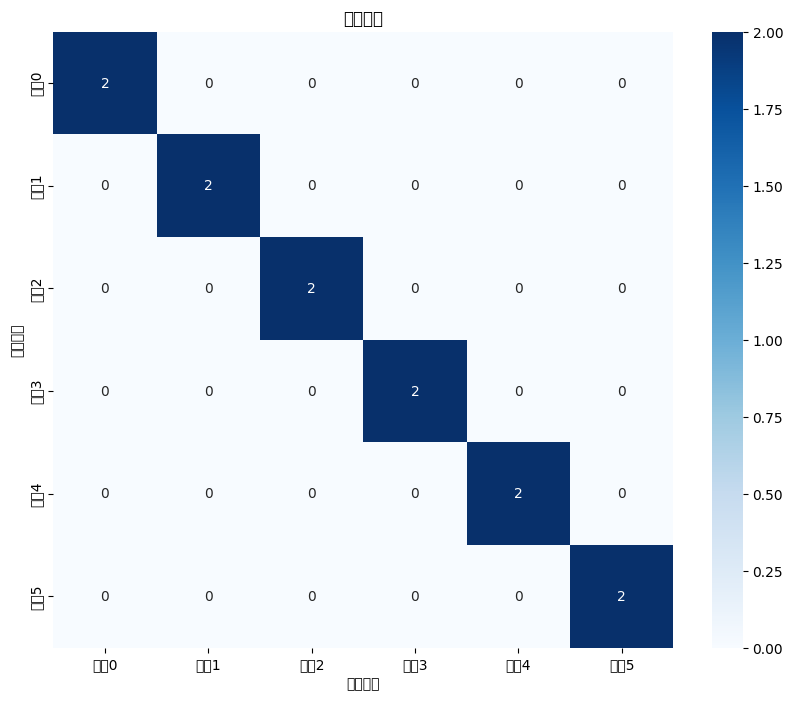

              precision    recall  f1-score   support

         动作0       1.00      1.00      1.00         2
         动作1       1.00      1.00      1.00         2
         动作2       1.00      1.00      1.00         2
         动作3       1.00      1.00      1.00         2
         动作4       1.00      1.00      1.00         2
         动作5       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [ ]:
# 回调函数
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_accuracy'
)

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# 加载最佳模型
model.load_weights('best_model.h5')

# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n测试准确率: {test_acc:.4f}, 测试损失: {test_loss:.4f}")

# 混淆矩阵
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

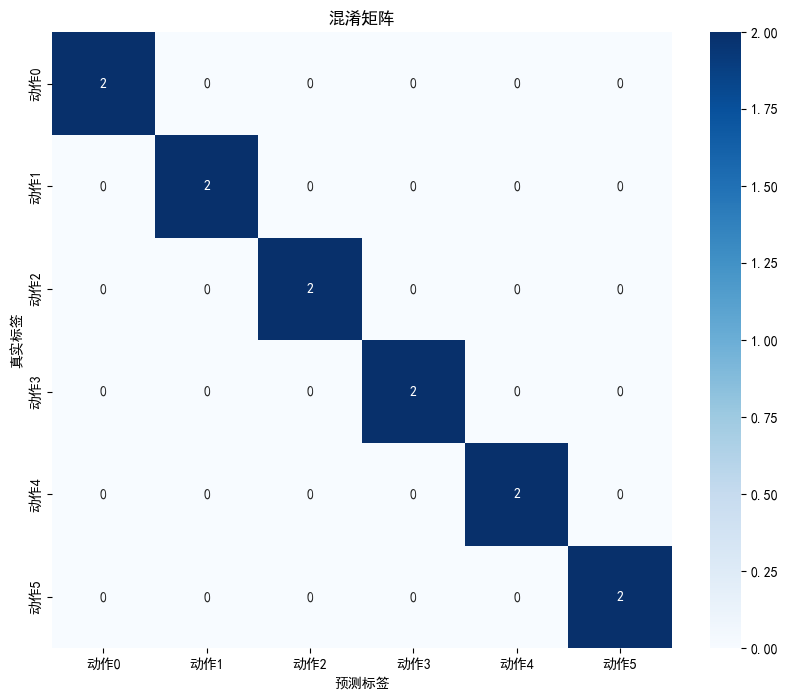

              precision    recall  f1-score   support

         动作0       1.00      1.00      1.00         2
         动作1       1.00      1.00      1.00         2
         动作2       1.00      1.00      1.00         2
         动作3       1.00      1.00      1.00         2
         动作4       1.00      1.00      1.00         2
         动作5       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体（SimHei）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"动作{i}" for i in range(6)],
            yticklabels=[f"动作{i}" for i in range(6)])
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('混淆矩阵')
plt.savefig('confusion_matrix.png')
plt.show()

# 分类报告
print(classification_report(y_true_classes, y_pred_classes, target_names=[f"动作{i}" for i in range(6)]))